#Libraries

In [57]:
!pip install findpeaks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=728a4ff6b63a9908c7d4c53afdc3b01307f9c593e5c58f7f71c68491de97c003
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [58]:
## file accessing 
import os
from os.path import isfile, join
import nibabel as nib

## image processing
import findpeaks
import cv2
from PIL import Image

## data processing and visualization
import numpy as np
import matplotlib.pyplot as plt
import scipy
from astropy.visualization import hist

## neural network
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset

## Evaluation
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import seaborn as sns

In [10]:
torch.manual_seed(4460)
np.random.seed(4460)

#Data Loading

##Preprocessing and Load NIFT data

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
MAIN_PATH = '/content/drive/MyDrive/Nerissa Research Project with Laine (sorry i ran out of GPU, this has nothing to do with DL project))'
NFTI_path = '/content/drive/MyDrive/Nerissa Research Project with Laine (sorry i ran out of GPU, this has nothing to do with DL project))/NFTI files'
sample_files = os.listdir(NFTI_path)
os.chdir(NFTI_path)

In [14]:
input_paths = []
truth_paths = []
names = []
for f in sample_files:
  series = os.listdir(f)
  for s in series:
    niis = os.listdir(f+'/'+s)
    truths = [i for i in niis if f in i and 'segments' in i]
    inputs = [i for i in niis if f in i and not('segments' in i)]
    for i, t in zip(inputs, truths):
      input_paths.append(f+'/'+s+'/'+i)
      truth_paths.append(f+'/'+s+'/'+t)
      names.append(f +'_'+ s)
    break

raw_imgs = []
truth_imgs = []
norm_imgs = []
img_names = []

for i, t, n in zip(input_paths, truth_paths, names):
  input_nii_img = nib.load(i)
  truth_nii_img = nib.load(t)
  input_data = input_nii_img.get_fdata()
  truth_data = truth_nii_img.get_fdata()


  for tp in range(input_data.shape[2]):
    ## preprocessing
    input = input_data[:, :, tp]
    truth = truth_data[:, :, tp]
    
    norm = cv2.normalize(input, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    input = cv2.resize(input, (256,256))
    truth = cv2.resize(truth, (256,256))
    norm = cv2.resize(norm, (256,256))
    
    raw_imgs.append(input)
    truth_imgs.append(truth)
    norm_imgs.append(norm)
    ## TO DO: image cannot be saved successfully; when read return None
    #input = Image.fromarray(input)
    #input.save('/content/drive/MyDrive/Colab Notebooks/LaineLab/Input/Raw Input/Raw_%s_%d.tif' %(n, tp+1))

    img_names.append("%s_%d" %(n, tp+1))

##Load saved Kuan data

In [15]:
def loadImgs(path, resize = False):
    files = os.listdir(path)
    os.chdir(path)

    imgs = []
    names = []
    for i in files:
      
      names.append(i.split('.')[0].split('_')[1:])
      img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)

      if resize:
        img = cv2.resize(img, (256,256))
      imgs.append(img)
    os.chdir(MAIN_PATH)
    return imgs, names

In [64]:
kuan_imgs, names = loadImgs('/content/drive/MyDrive/Nerissa Research Project with Laine (sorry i ran out of GPU, this has nothing to do with DL project))/Kuan Input', resize = True)

Text(0.5, 1.0, 'Ground Truth')

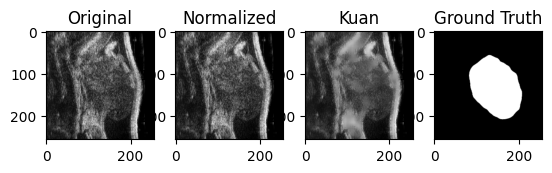

In [66]:
idx = 100
plt.subplot(141)
plt.imshow(raw_imgs[idx], cmap='gray'); plt.title('Original')
plt.subplot(142)
plt.imshow(norm_imgs[idx], cmap='gray');  plt.title('Normalized')
plt.subplot(143)
plt.imshow(kuan_imgs[idx], cmap='gray'); plt.title('Kuan')
plt.subplot(144)
plt.imshow(truth_imgs[idx], cmap='gray'); plt.title('Ground Truth')

#Image Preprocessing (not necessary after first run)

##Tumor & background instensity Analysis

In [ ]:
tumor_intensities = []
background_intensities = []
contours = []
idx = 0
pre_idxs = []
for img, truth in zip(input_imgs, truth_imgs):
  tumor = np.multiply(img, truth)
  tumor = np.array(tumor, np.uint8) 
  contour = cv2.findContours(tumor, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]

  if not contour:
    idx += 1
    continue
  else:
    contour= contour[0]

  total, background, b, c = 0, 0, 0, 0
  contours.append(contour)
  for i in range(tumor.shape[0]):
    for j in range(tumor.shape[1]):
      if cv2.pointPolygonTest(contour, (j,i), False) >= 0:
        total += tumor[i,j]
        c += 1
      else:
        background += img[i,j]
        b += 1
  tumor_intensities.append(total/ c)
  background_intensities.append(background/ b)
  pre_idxs.append(idx)
  idx += 1



In [ ]:
eq_tumor_intensities = []
eq_background_intensities = []

for img, truth in zip(input_imgs, truth_imgs):
  img = np.uint8(img)
  img = cv2.equalizeHist(img)
  tumor = np.multiply(img, truth)
  tumor = np.array(tumor, np.uint8) 
  contour = cv2.findContours(tumor, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]

  if not contour:
    idx += 1
    continue
  else:
    contour= contour[0]

  total, background, b, c = 0, 0, 0, 0

  for i in range(tumor.shape[0]):
    for j in range(tumor.shape[1]):
      if cv2.pointPolygonTest(contour, (j,i), False) >= 0:
        total += tumor[i,j]
        c += 1
      else:
        background += img[i,j]
        b += 1
  eq_tumor_intensities.append(total/ c)
  eq_background_intensities.append(background/ b)




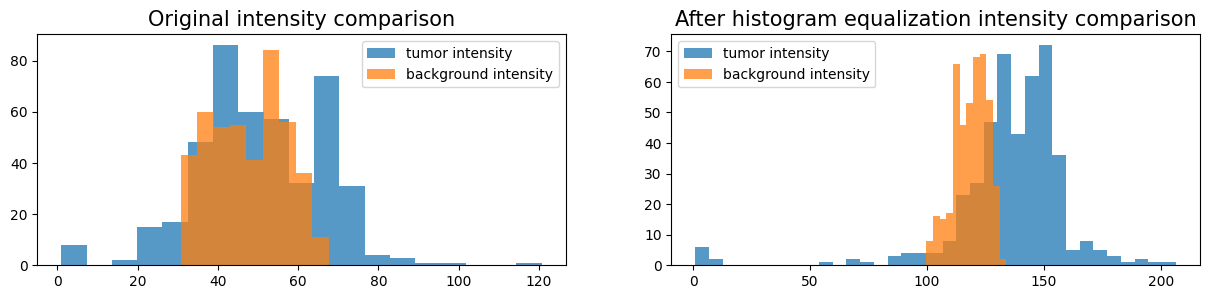

In [ ]:
plt.figure(figsize = (15,3))
# The Freedman-Diaconis rule: ℎ=2×IQR×𝑛−1/3; num_bins = (max−min)/ℎ
plt.subplot(121)
plt.title('Original intensity comparison', fontsize = 15)

hist(tumor_intensities, bins ='freedman', alpha = 0.75, label = 'tumor intensity'); plt.legend()
hist(background_intensities, bins = 'freedman', alpha = 0.75, label = 'background intensity'); plt.legend()

plt.subplot(122)
plt.title('After histogram equalization intensity comparison', fontsize = 15)
hist(eq_tumor_intensities, bins = 'freedman', alpha = 0.75, label = 'tumor intensity'); plt.legend()
hist(eq_background_intensities, bins = 'freedman',  alpha = 0.75, label = 'background intensity'); plt.legend()



##Otsu Thresholding

"\ntumor2 = np.multiply(sample_img2, sample_truth2)\ntumor2 = np.array(tumor2, np.uint8)\nimg2 = np.array(sample_img2, np.uint8)\nret,th2 = cv2.threshold(img2 ,0,255, cv2.THRESH_BINARY, cv2.THRESH_OTSU)\nplt.subplot(234)\nplt.imshow(th2, cmap = 'gray'); plt.title('otsu thresh')\nplt.subplot(235)\nplt.imshow(sample_img2, cmap = 'gray', label = 'original');plt.title('original')\nplt.subplot(236)\nplt.imshow(np.multiply(sample_img2, th2), cmap = 'gray'); plt.title('otsu multiply')\n"

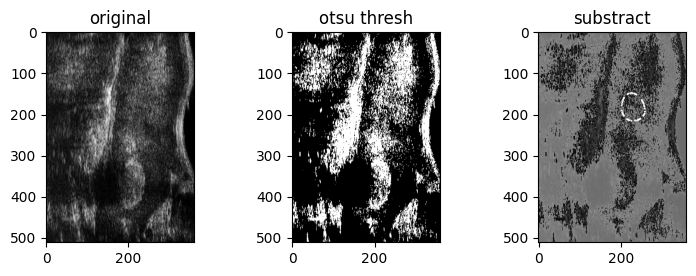

In [ ]:
sample_img = input_imgs[pre_idxs[0]]
sample_truth = truth_imgs[pre_idxs[0]]
sample_img2 = input_imgs[pre_idxs[0]]
sample_truth2 = truth_imgs[pre_idxs[0]]
cont = contours[1]

plt.figure(figsize = (9,6))

tumor = np.multiply(sample_img, sample_truth)
tumor = np.array(tumor, np.uint8)
img = np.array(sample_img, np.uint8)
ret,th1 = cv2.threshold(img,0,255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.subplot(232)
plt.imshow(th1, cmap = 'gray'); plt.title('otsu thresh')
plt.subplot(231)
plt.imshow(sample_img, cmap = 'gray', label = 'original');plt.title('original')
plt.subplot(233)
copy = ((sample_img - th1))
cv2.drawContours(copy, cont, -1, (255,255,255), 3)
plt.imshow(copy, cmap = 'gray'); plt.title('substract')
'''
tumor2 = np.multiply(sample_img2, sample_truth2)
tumor2 = np.array(tumor2, np.uint8)
img2 = np.array(sample_img2, np.uint8)
ret,th2 = cv2.threshold(img2 ,0,255, cv2.THRESH_BINARY, cv2.THRESH_OTSU)
plt.subplot(234)
plt.imshow(th2, cmap = 'gray'); plt.title('otsu thresh')
plt.subplot(235)
plt.imshow(sample_img2, cmap = 'gray', label = 'original');plt.title('original')
plt.subplot(236)
plt.imshow(np.multiply(sample_img2, th2), cmap = 'gray'); plt.title('otsu multiply')
'''

##Equalization histogram

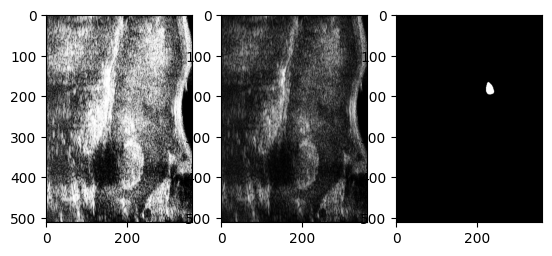

In [ ]:
plt.subplot(131)
plt.imshow(cv2.equalizeHist(np.uint8(sample_img)), cmap = 'gray')
plt.subplot(132)
plt.imshow(sample_img, cmap = 'gray')
plt.subplot(133)
plt.imshow(sample_truth, cmap = 'gray')

##Kuan Filtering

In [60]:
img_names = ['_'.join(i.split(' ')) for i in img_names]

In [63]:
# Modified from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

#fastnl_imgs = []
#bilateral_imgs = []
#frost_imgs = []
kuan_imgs = []
#lee_imgs = []
#lee_enhanced_imgs = []
#mean_imgs = []
#median_imgs = []

## filters parameters
# window size
winsize = 15
# damping factor for frost
k_value1 = 2.0
# damping factor for lee enhanced
k_value2 = 1.0
# coefficient of variation of noise
cu_value = 0.25
# coefficient of variation for lee enhanced of noise
cu_lee_enhanced = 0.523
# max coefficient of variation for lee enhanced
cmax_value = 1.73

for img, name in zip(raw_imgs, img_names):
  ## Scale between [0-255]
  img = findpeaks.stats.scale(img)

  ## Denoising
  #fastnl_imgs.append(findpeaks.stats.denoise(img, method='fastnl', window=winsize))
  #bilateral_imgs.append(findpeaks.stats.denoise(img, method='bilateral', window=winsize))
  #frost_imgs.append(findpeaks.frost_filter(img, damping_factor=k_value1, win_size=winsize))

  data = findpeaks.kuan_filter(img, win_size=winsize, cu=cu_value).astype(np.uint8)
  im = Image.fromarray(data)
  im.save('/content/drive/MyDrive/Nerissa Research Project with Laine (sorry i ran out of GPU, this has nothing to do with DL project))/Kuan Input/kuan_%s.tif' %name)
  kuan_imgs.append(data)

  #lee_imgs.append(findpeaks.lee_filter(img, win_size=winsize, cu=cu_value))
  #lee_enhanced_imgs.append(findpeaks.lee_enhanced_filter(img, win_size=winsize, k=k_value2, cu=cu_lee_enhanced, cmax=cmax_value))
  #mean_imgs.append(findpeaks.mean_filter(img, win_size=winsize))
  #median_imgs.append(findpeaks.median_filter(img, win_size=winsize))

[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Scaling image between [0-255] and t

Text(0.5, 1.0, 'Segmentation')

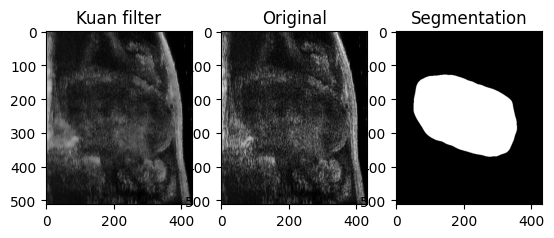

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/LaineLab/Input/kuan_100.tif')
plt.subplot(131)
plt.imshow(img); plt.title('Kuan filter')
plt.subplot(132)
plt.imshow(raw_imgs[100], cmap ='gray'); plt.title('Original')
plt.subplot(133)
plt.imshow(truth_imgs[100], cmap ='gray'); plt.title('Segmentation')

In [ ]:
class Kuan(object):
    def __call__(self, img):
        """
        :param img: np.array

        :return: kuan_filtered img (np.array)
        """
        img = cv2.imread(img)  
        img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
        kuan_img = findpeaks.kuan_filter(img, win_size=winsize, cu=cu_value).astype(np.uint8)
        return kuan_img

    def __repr__(self):
        return self.__class__.__name__+'()'

#Make Datasets


In [67]:
# input_imgs or kuan_imgs
X_input, X_test, y_input, y_test = train_test_split(kuan_imgs, truth_imgs, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_input, y_input, test_size=1/9, random_state=42)

## Covert to correct datatype before making TensorDataset
X_train = torch.from_numpy(np.stack(X_train, axis=0)).type(torch.FloatTensor).view(-1, 1, 256, 256)
X_valid = torch.from_numpy(np.stack(X_valid, axis=0)).type(torch.FloatTensor).view(-1, 1, 256, 256)
X_test = torch.from_numpy(np.stack(X_test, axis=0)).type(torch.FloatTensor).view(-1, 1, 256, 256)
X_input = torch.from_numpy(np.stack(X_input, axis=0)).type(torch.FloatTensor).view(-1, 1, 256, 256)

y_train = torch.from_numpy(np.stack(y_train, axis=0)).type(torch.LongTensor).view(-1, 256, 256)
y_valid = torch.from_numpy(np.stack(y_valid, axis=0)).type(torch.LongTensor).view(-1, 256, 256)
y_test = torch.from_numpy(np.stack(y_test, axis=0)).type(torch.LongTensor).view(-1, 256, 256)
y_input = torch.from_numpy(np.stack(y_input, axis=0)).type(torch.LongTensor).view(-1, 256, 256)

In [68]:
## Dataset
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
input_dataset = TensorDataset(X_input, y_input)

test_dataset = TensorDataset(X_test, y_test)

## Dataloader
train_loader = DataLoader(train_dataset, batch_size = 3, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 3, shuffle = True)
input_loader = DataLoader(input_dataset, batch_size = 3, shuffle = True)

test_loader = DataLoader(test_dataset, batch_size = 3, shuffle = True)

#Model Architecture

In [21]:
######################################## Double Convolution
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

    
######################################## Maxpooling followed by Double Convolution
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


######################################## Upsampling followed by Double Convolution
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_conv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
        ) 
        self.conv = DoubleConv(out_channels * 2, out_channels)


    def forward(self, x1, x2):
        x1 = self.up_conv(x1)
        x = torch.cat([x1, x2], dim=1)
        x = self.conv(x)
        return x

######################################## Output layer (1x1 Convolution followed by SoftMax activation)
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv_sigmoid = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            #nn.Sigmoid()
            nn.Softmax(dim = 1)
        )

    def forward(self, x):
        return self.conv_sigmoid(x)

In [22]:
class UNet(nn.Module):

    def __init__(self, name, n_channels, n_classes):
        super(UNet, self).__init__()
        self.name = name
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inputL = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.down5 = Down(512, 1024)
        
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 512)
        self.up3 = Up(512, 256)
        self.up4 = Up(256, 128)
        self.up5 = Up(128, 64)
        self.outputL = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inputL(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        b = self.down5(x5)
        
        
        x = self.up1(b, x5)
        x = self.up2(x, x4)
        x = self.up3(x, x3)
        x = self.up4(x, x2)
        x = self.up5(x, x1)
        
        x = self.outputL(x)
        return x

#Train/ Evalutation Helper functions

##Early Stopping

In [23]:
#Github source: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, name, patience=3, verbose=False, delta=0, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = name + '_checkpoint.pt'
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score <= self.best_score + self.delta: # not improving
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

##Training function

In [24]:
# Define a function that computes the Jaccard score for binary segmentation
def jaccard_coeff_binary(y_pred, y_true):
        S = dice_coeff_binary(y_pred, y_true)
        return S/(2-S)

# Define a function that computes the DICE score for binary segmentation
def dice_coeff_binary(y_pred, y_true):
        eps = 0.0001
        inter = torch.dot(y_pred.view(-1).float(), y_true.view(-1).float())
        union = torch.sum(y_pred.float()) + torch.sum(y_true.float())
        return ((2 * inter.float() + eps) / (union.float() + eps)).cpu().numpy()
    

# The training function
def train_net(net, epochs, train_dataloader, valid_dataloader, optimizer, loss_function):
    
    
    n_train = len(train_dataloader)
    n_valid = len(valid_dataloader)    
    
    train_loss = list()
    valid_loss = list()
    train_dice = list()
    valid_dice = list()
    train_jaccard = list()
    valid_jaccard = list()
    
    early_stopping = EarlyStopping(net.name, patience=7, verbose=True)

    for epoch in range(epochs):
        
        ################################################################################################################################
        ########################################################### Training ###########################################################
        ################################################################################################################################
        net.train()
        train_batch_loss = list()
        train_batch_dice = list()
        train_batch_jaccard = list()
        
        for i, batch in enumerate(train_dataloader):

            # Load a batch and pass it to the GPU
            imgs = batch[0].cuda()
            true_masks = batch[1].cuda()
 
            # Produce the estimated mask using current weights
            y_pred = net(imgs)
            # Compute the loss for this batch and append it to the epoch loss
            loss = loss_function(y_pred, true_masks)
            batch_loss = loss.item()
            train_batch_loss.append(batch_loss)

            # Make the binary mask to compute the DICE score. Since the y_pred is a Pytoch tensor, we use `torch.argmax()` instead of `np.argmax()`.
            # the axis must be 1 instead of 0 because the format is [batch, channel, height, width]
            pred_binary = torch.argmax(y_pred, axis=1)
            
            # Compute the DICE score for this batch and append it to the epoch dice
            batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
            train_batch_dice.append(batch_dice_score)
            
            # Compute the Jaccard score here and 
            batch_jaccard_score = jaccard_coeff_binary(pred_binary, true_masks)
            train_batch_jaccard.append(batch_jaccard_score)
            

            # Reset gradient values
            optimizer.zero_grad()

            # Compute the backward losses
            loss.backward()

            # Update the weights
            optimizer.step()
            
            # Print the progress
            print(f'EPOCH {epoch + 1}/{epochs} - Training Batch {i+1}/{n_train} - Loss: {batch_loss}, DICE score: {batch_dice_score}, Jaccard score: {batch_jaccard_score}            ', end='\r')
        
        average_training_loss = np.array(train_batch_loss).mean()
        average_training_dice = np.array(train_batch_dice).mean()
        average_training_jaccard = np.array(train_batch_jaccard).mean()
        train_loss.append(average_training_loss)
        train_dice.append(average_training_dice)
        train_jaccard.append(average_training_jaccard)
        
        ################################################################################################################################
        ########################################################## Validation ##########################################################
        ################################################################################################################################
        
        net.eval()
        valid_batch_loss = list()
        valid_batch_dice = list()
        valid_batch_jaccard = list()
        
        # This part is almost the same as training with the difference that we will set all layers to evaluation mode (effects some layers such as BN and Dropout) and also
        # we don't need to calculate the gradient since we are only evaluating current state of the model. This will speed up the process and cause it to consume less memory.
        with torch.no_grad():
            for i, batch in enumerate(valid_dataloader):

                # Load a batch and pass it to the GPU
                imgs = batch[0].cuda()
                true_masks = batch[1].cuda()

                # Produce the estimated mask using current weights
                y_pred = net(imgs)

                # Compute the loss for this batch and append it to the epoch loss
                loss = loss_function(y_pred, true_masks)
                batch_loss = loss.item()
                valid_batch_loss.append(batch_loss)

                # Make the binary mask to compute the DICE score. Since the y_pred is a Pytoch tensor, we use `torch.argmax()` instead of `np.argmax()`.
                # the axis must be 1 instead of 0 because the format is [batch, channel, height, width]
                pred_binary = torch.argmax(y_pred, axis=1)

                # Compute the DICE score for this batch and append it to the epoch dice
                batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
                valid_batch_dice.append(batch_dice_score)
                
                # Compute the Jaccard score here and append the score to the list
                batch_jaccard_score = jaccard_coeff_binary(pred_binary, true_masks)
                valid_batch_jaccard.append(batch_jaccard_score)

                # Print the progress
                print(f'EPOCH {epoch + 1}/{epochs} - Validation Batch {i+1}/{n_valid} - Loss: {batch_loss}, DICE score: {batch_dice_score}, Jaccard score: {batch_jaccard_score}            ', end='\r')
                
        average_validation_loss = np.array(valid_batch_loss).mean()
        average_validation_dice = np.array(valid_batch_dice).mean()
        average_validation_jaccard = np.array(valid_batch_jaccard).mean()
        valid_loss.append(average_validation_loss)
        valid_dice.append(average_validation_dice)
        valid_jaccard.append(average_validation_jaccard)
        
        print(f'EPOCH {epoch + 1}/{epochs} - Training Loss: {average_training_loss}, Training DICE score: {average_training_dice}, Training Jaccard score: {average_training_jaccard}, Validation Loss: {average_validation_loss}, Validation DICE score: {average_validation_dice}, Validation Jaccard score: {average_validation_jaccard}')

        ################################################################################################################################
        ###################################################### Saveing Checkpoints #####################################################
        ################################################################################################################################
        early_stopping(average_validation_loss, net)
        if early_stopping.early_stop:
            print("Early stopping at epoch %d" %epoch)
            #torch.save(dnresunet.state_dict(), f'{dnresunet.name}/epoch_{epoch+1:03}.pth')
            net.load_state_dict(torch.load(net.name+'_checkpoint.pt'))
            net.cuda()
            break

    
    return train_loss, train_dice, train_jaccard, valid_loss, valid_dice, valid_jaccard

##Evaluation functions

In [25]:
def test_net(net, test_dataloader, loss_function):    
    net.eval()
    
    n_test = len(test_dataloader)
    test_batch_loss = list()
    test_batch_dice = list()
    test_batch_jaccard = list()
    test_batch_accuray = list()
    test_batch_CM = list()

    # This part is almost the same as the validation loop in `train_net` function. 
    # The difference is that we will calculate the accuracy and confusion matrix per each batch and save the predicted images.
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):

            # Load a batch and pass it to the GPU
            imgs = batch[0].cuda()
            true_masks = batch[1].cuda()

            # Produce the estimated mask using current weights
            y_pred = net(imgs)

            # Compute the loss for this batch and append it to the epoch loss
            loss = loss_function(y_pred, true_masks)
            batch_loss = loss.item()
            test_batch_loss.append(batch_loss)

            # Make the binary mask to compute the DICE score. Since the y_pred is a Pytoch tensor, we use `torch.argmax()` instead of `np.argmax()`.
            # the axis must be 1 instead of 0 because the format is [batch, channel, height, width]
            pred_binary = torch.argmax(y_pred, axis=1)

            # Compute the DICE score for this batch and append it to the epoch dice
            batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
            test_batch_dice.append(batch_dice_score)
            
            # Compute the Jaccard score for this batch and append it to the epoch dice
            batch_jaccard_score = jaccard_coeff_binary(pred_binary, true_masks)
            test_batch_jaccard.append(batch_jaccard_score)
            
            # Vectorize the true mask and predicted mask for this batch
            vectorize_true_masks = true_masks.view(-1).cpu().numpy()
            vectorize_pred_masks = pred_binary.view(-1).cpu().numpy()
            
            # Compute the accuracy for this batch and append to the overall list
            batch_accuracy = accuracy_score(vectorize_true_masks, vectorize_pred_masks)
            test_batch_accuray.append(batch_accuracy)
            
            # Compute the normalized confusion matrix for this batch and append to the overall list
            batch_CM = confusion_matrix(vectorize_true_masks, vectorize_pred_masks, normalize='true', labels=[0, 1])
            test_batch_CM.append(batch_CM)

            # Print the progress
            print(f'Test Batch {i+1}/{n_test} - Loss: {batch_loss}, DICE score: {batch_dice_score}, Jaccard score: {batch_jaccard_score}, Accuracy: {batch_accuracy}', end='\r')

    test_loss = np.array(test_batch_loss).mean()
    test_dice = np.array(test_batch_dice).mean()
    test_jaccard = np.array(test_batch_jaccard).mean()
    test_accuracy = np.array(test_batch_accuray).mean()
    test_CM = np.array(test_batch_CM).mean(axis=0)
    
    return test_loss, test_dice, test_jaccard, test_accuracy, test_CM

#Run Training

In [69]:
os.chdir(MAIN_PATH)

In [71]:
inp_channel = 1
opt_channel = 2
unet = UNet('kuan_UNet', inp_channel, opt_channel)

if torch.cuda.is_available():
  print("GPU available:", torch.cuda)
  unet.cuda()
else:
  print('SWITCH TO GPU')

GPU available: <module 'torch.cuda' from '/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py'>


In [72]:
optimizer = torch.optim.Adam(unet.parameters(), lr=10**-6)
loss_function = nn.CrossEntropyLoss()

In [73]:
EPOCHS = 50
train_loss, train_dice, train_jaccard, valid_loss, valid_dice, valid_jaccard = train_net(unet, EPOCHS, train_loader, valid_loader, optimizer, loss_function)

EPOCH 1/50 - Training Loss: 0.6389207885815547, Training DICE score: 0.3125884532928467, Training Jaccard score: 0.20032238019844123, Validation Loss: 0.6053793986638387, Validation DICE score: 0.4509304165840149, Validation Jaccard score: 0.3113662645531612
Validation loss decreased (inf --> 0.605379).  Saving model ...
EPOCH 2/50 - Training Loss: 0.593987282524761, Training DICE score: 0.5168251395225525, Training Jaccard score: 0.38190637729718063, Validation Loss: 0.5689962188402812, Validation DICE score: 0.5498188138008118, Validation Jaccard score: 0.4148630644635001
Validation loss decreased (0.605379 --> 0.568996).  Saving model ...
EPOCH 3/50 - Training Loss: 0.5645617975129021, Training DICE score: 0.618149995803833, Training Jaccard score: 0.48846406240260015, Validation Loss: 0.5276878515879313, Validation DICE score: 0.7163697481155396, Validation Jaccard score: 0.5905665397831348
Validation loss decreased (0.568996 --> 0.527688).  Saving model ...
EPOCH 4/50 - Training L

## Raw2 plot

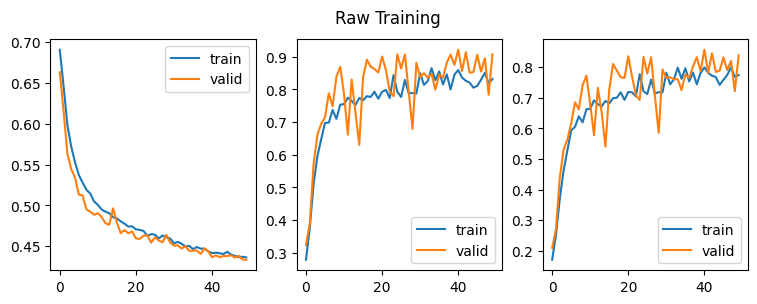

In [51]:
raw2_tloss = train_loss[:]
raw2_tdice = train_dice[:]
raw2_tjaccard = train_jaccard[:]
raw2_vloss = valid_loss[:]
raw2_vdice = valid_dice[:]
raw2_vjaccard = valid_jaccard[:]

plt.figure(figsize=(9,3))
plt.suptitle('Raw Training')
plt.subplot(131)
plt.xlabel('Epcoh')
plt.ylabel('CE Loss')
plt.plot(raw2_tloss, label ='train'); plt.legend()
plt.plot(raw2_vloss, label ='valid'); plt.legend()

plt.subplot(132)
plt.xlabel('Epcoh')
plt.ylabel('Dice')
plt.plot(raw2_tdice, label ='train'); plt.legend()
plt.plot(raw2_vdice, label ='valid'); plt.legend()

plt.subplot(133)
plt.xlabel('Epcoh')
plt.ylabel('Jaccard')
plt.plot(raw2_tjaccard, label ='train'); plt.legend()
plt.plot(raw2_vjaccard, label ='valid'); plt.legend()

## Norm plot

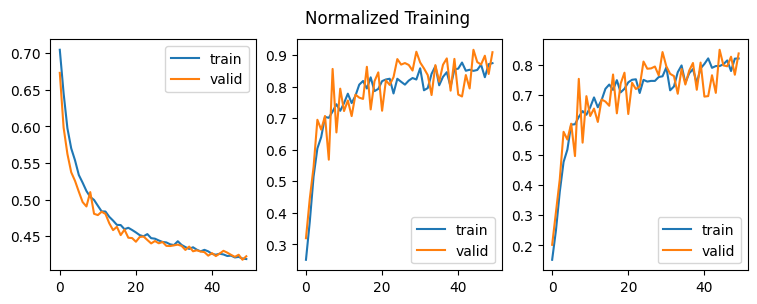

In [45]:
norm_tloss = train_loss[:]
norm_tdice = train_dice[:]
norm_tjaccard = train_jaccard[:]
norm_vloss = valid_loss[:]
norm_vdice = valid_dice[:]
norm_vjaccard = valid_jaccard[:]

plt.figure(figsize=(9,3))
plt.suptitle('Normalized Training')
plt.subplot(131)
plt.xlabel('Epcoh')
plt.ylabel('CE Loss')
plt.plot(norm_tloss, label ='train'); plt.legend()
plt.plot(norm_vloss, label ='valid'); plt.legend()

plt.subplot(132)
plt.xlabel('Epcoh')
plt.ylabel('Dice')
plt.plot(norm_tdice, label ='train'); plt.legend()
plt.plot(norm_vdice, label ='valid'); plt.legend()

plt.subplot(133)
plt.xlabel('Epcoh')
plt.ylabel('Jaccard')
plt.plot(norm_tjaccard, label ='train'); plt.legend()
plt.plot(norm_vjaccard, label ='valid'); plt.legend()

##Kuan plot

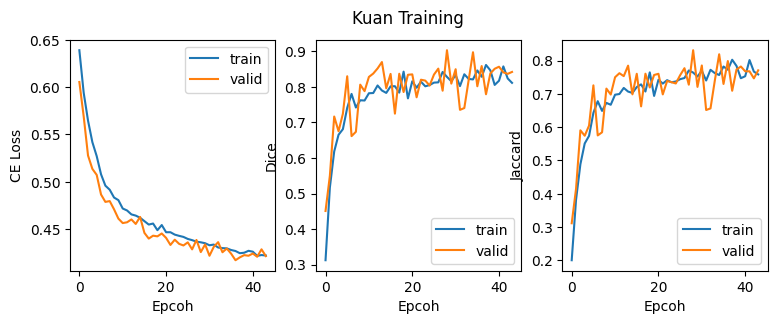

In [75]:
kuan_tloss = train_loss[:]
kuan_tdice = train_dice[:]
kuan_tjaccard = train_jaccard[:]
kuan_vloss = valid_loss[:]
kuan_vdice = valid_dice[:]
kuan_vjaccard = valid_jaccard[:]

plt.figure(figsize=(9,3))
plt.suptitle('Kuan Training')
plt.subplot(131)
plt.xlabel('Epcoh')
plt.ylabel('CE Loss')
plt.plot(kuan_tloss, label ='train'); plt.legend()
plt.plot(kuan_vloss, label ='valid'); plt.legend()

plt.subplot(132)
plt.xlabel('Epcoh')
plt.ylabel('Dice')
plt.plot(kuan_tdice, label ='train'); plt.legend()
plt.plot(kuan_vdice, label ='valid'); plt.legend()

plt.subplot(133)
plt.xlabel('Epcoh')
plt.ylabel('Jaccard')
plt.plot(kuan_tjaccard, label ='train'); plt.legend()
plt.plot(kuan_vjaccard, label ='valid'); plt.legend()

#Result

In [76]:
inp_channel = 1
opt_channel = 2
rawunet = UNet('raw_UNet', inp_channel, opt_channel)
normunet = UNet('norm_UNet', inp_channel, opt_channel)
kuanunet = UNet('kuan_UNet', inp_channel, opt_channel)
if torch.cuda.is_available():
  print("GPU available:", torch.cuda)

else:
  print('SWITCH TO GPU')

rawunet.load_state_dict(torch.load(rawunet.name+'_checkpoint.pt'))
normunet.load_state_dict(torch.load(normunet.name+'_checkpoint.pt'))
kuanunet.load_state_dict(torch.load(kuanunet.name+'_checkpoint.pt'))
rawunet.cuda()
normunet.cuda()
kuanunet.cuda()



GPU available: <module 'torch.cuda' from '/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py'>


UNet(
  (inputL): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, mom

In [79]:
nets = [rawunet, normunet, kuanunet]
test_loss, test_dice, test_jaccard, test_accuracy, test_CM = [], [], [], [], []

for net in nets:
  loss, dice, jaccard, accuracy, CM = test_net(rawunet, test_loader, loss_function)
  test_loss.append(loss)
  test_dice.append(dice)
  test_jaccard.append(jaccard)
  test_accuracy.append(accuracy)
  test_CM.append(CM)

In [81]:
d = {'loss': test_loss, 'Dice':test_dice, 'Jaccard': test_jaccard, 'accuracy':test_accuracy}
df = pd.DataFrame(data=d, index=['raw', 'norm', 'kuan'])
df.head()

,loss,Dice,Jaccard,accuracy
raw,0.446153,0.457238,0.349304,0.954543
norm,0.446296,0.526555,0.422532,0.954299
kuan,0.447080,0.531618,0.414728,0.953131


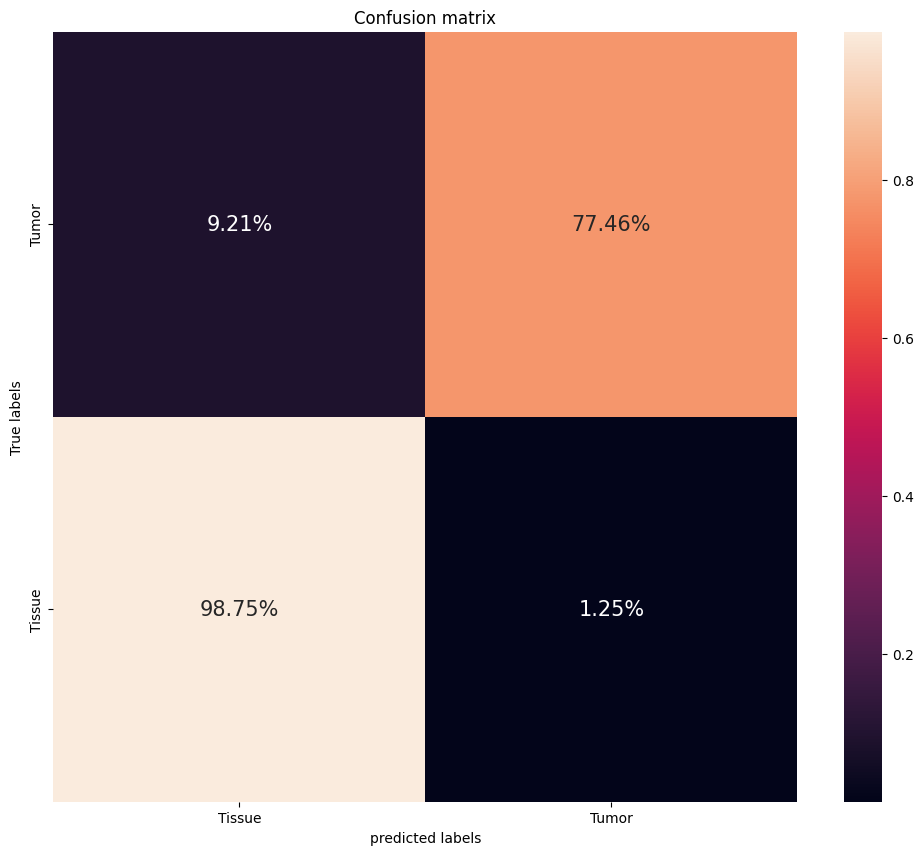

In [ ]:
df_cm = pd.DataFrame(test_CM, index = ['Tissue', 'Tumor'],
                     columns = ['Tissue', 'Tumor'])
plt.figure(figsize = (12,10))
plt.title('Confusion matrix')
sns.heatmap(df_cm, annot = True, fmt='.2%', annot_kws = {"size": 15})
plt.ylim([0, 2]);
plt.ylabel('True labels');
plt.xlabel('predicted labels');

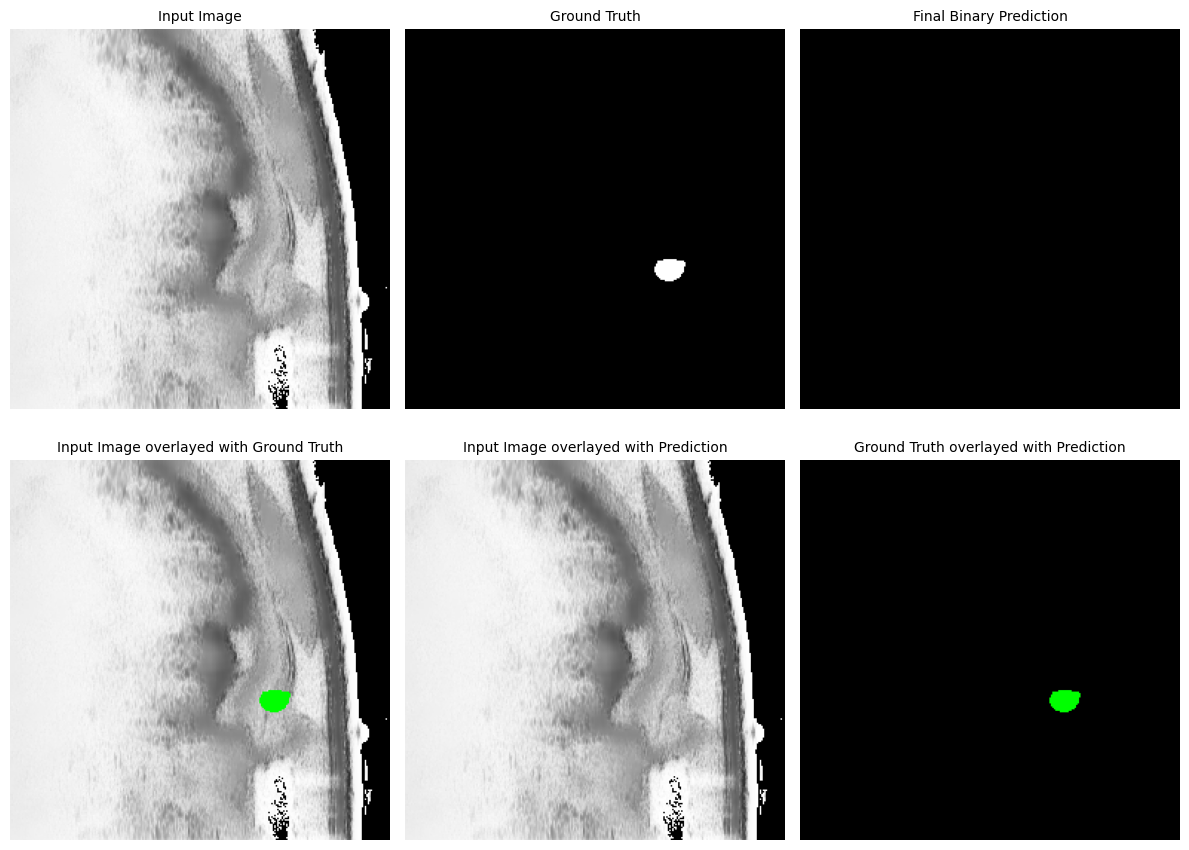

In [82]:
# Take the first batch of test set
idx = 0
for i, batch in enumerate(test_loader):
    if i == idx:
      sample_batch = batch
      break
    
# Generat network prediction
with torch.no_grad():
    y_pred = kuanunet(sample_batch[0].cuda())

                                                                                                                   
img = (sample_batch[0][0][0].numpy() * 255).astype('uint8')
msk = (sample_batch[1][0].numpy() * 255).astype('uint8')


pred_msk_binary = (np.argmax(y_pred.cpu().numpy()[0], axis=0) * 255).astype('uint8')


# Plot the smaple, ground truth, the prediction probability map, and the final predicted mask
plt.figure(figsize=(12,9))


plt.subplot(2,3,1)
plt.title('Input Image', fontsize=10)
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(2,3,2)
plt.title('Ground Truth', fontsize=10)
plt.imshow(msk, cmap='gray')
plt.axis('off')


plt.subplot(2,3,3)
plt.title('Final Binary Prediction', fontsize=10)
plt.imshow(pred_msk_binary, cmap='gray')
plt.axis('off')

input_overlayed_GT = img.copy()
input_overlayed_GT = cv2.cvtColor(input_overlayed_GT, cv2.COLOR_GRAY2RGB)
input_overlayed_GT[msk == 255, :] = [0, 255, 0]
plt.subplot(2,3,4)
plt.title('Input Image overlayed with Ground Truth', fontsize=10)
plt.imshow(input_overlayed_GT)
plt.axis('off')

input_overlayed_Pred = img.copy()
input_overlayed_Pred = cv2.cvtColor(input_overlayed_Pred, cv2.COLOR_GRAY2RGB)
input_overlayed_Pred[pred_msk_binary == 255, :] = [255, 0, 0]
plt.subplot(2,3,5)
plt.title('Input Image overlayed with Prediction', fontsize=10)
plt.imshow(input_overlayed_Pred)
plt.axis('off')

GT_overlayed_prediction = np.zeros_like(img)
GT_overlayed_prediction = cv2.cvtColor(GT_overlayed_prediction, cv2.COLOR_GRAY2RGB)
GT_overlayed_prediction[msk == 255, 1] = 255
GT_overlayed_prediction[pred_msk_binary == 255, 0] = 255
plt.subplot(2,3,6)
plt.title('Ground Truth overlayed with Prediction', fontsize=10)
plt.imshow(GT_overlayed_prediction)
plt.axis('off')

plt.tight_layout()
plt.show()